# ex6：Support Vector Machines
使用SVM构造一个垃圾邮件分类器

## 1. support vector machines
从一些简单的2D数据集开始使用SVM来查看它们的工作原理。

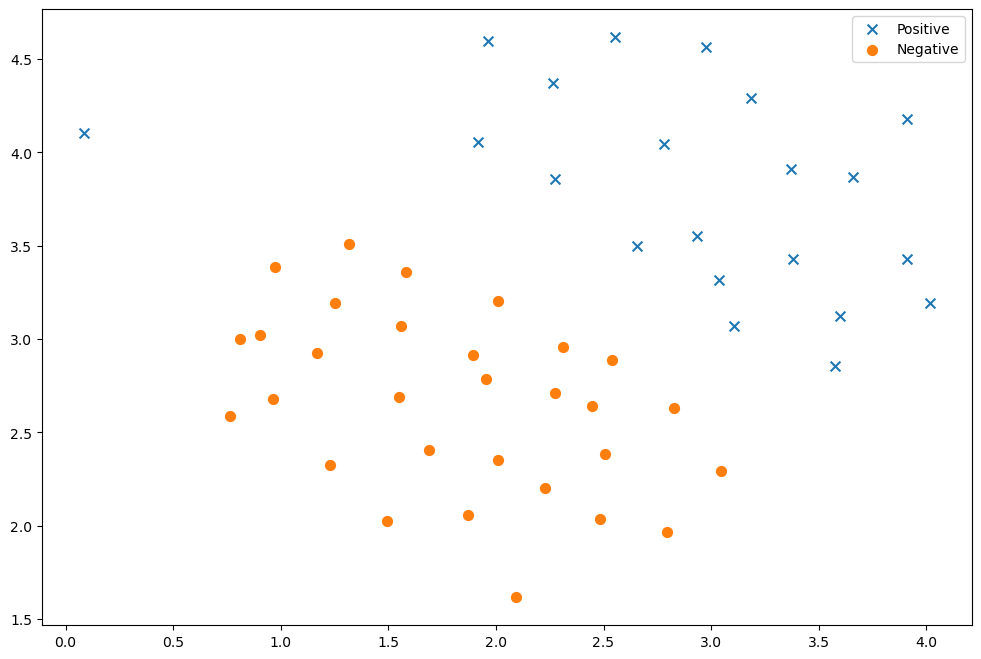

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from sklearn import svm

raw_data1 = loadmat('data/ex6data1.mat')
data1 = pd.DataFrame(raw_data1['X'], columns=['X1', 'X2'])
data1['y'] = raw_data1['y']

def plot_scatter(data):  
    positive = data[data['y'] == 1]
    negative = data[data['y'] == 0]

    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')
    ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')
    ax.legend()

plot_scatter(data1)

### 代价函数：
<img src = "cost.jpg" width = 500>
其中C为误差项惩罚系数，C越大，容错率越低，越易过拟合。  
在这一部分的练习中，你将尝试在SVM中使用参数C的不同值，来观察SVM的分类结果。

In [2]:
def plot_boundary(model, data, extension):
    x1_max, x1_min = np.max(data['X1']) + extension, np.min(data['X1']) - extension
    x2_max, x2_min = np.max(data['X2']) + extension, np.min(data['X2']) - extension

#     x1_max, x1_min = 5, 0
#     x2_max, x2_min = 5, 0

    x1, x2 = np.meshgrid(np.linspace(x1_max, x1_min, 500), np.linspace(x2_max, x2_min, 500))
    
    y_pred = model.predict(np.c_[x1.flatten(), x2.flatten()])
#     y_pred = model.predict(pd.DataFrame(np.c_[x1.flatten(), x2.flatten()]).values)
    
    
    y_pred = y_pred.reshape(x1.shape)
    plt.contour(x1, x2, y_pred, colors='g')


C=1: 0.9803921568627451
C=450: 1.0


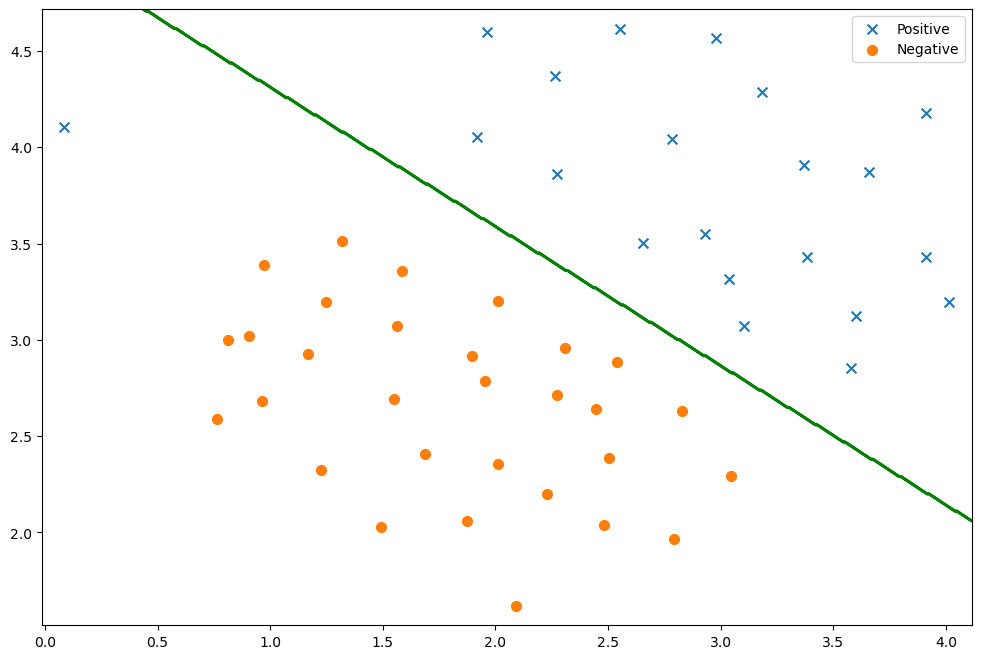

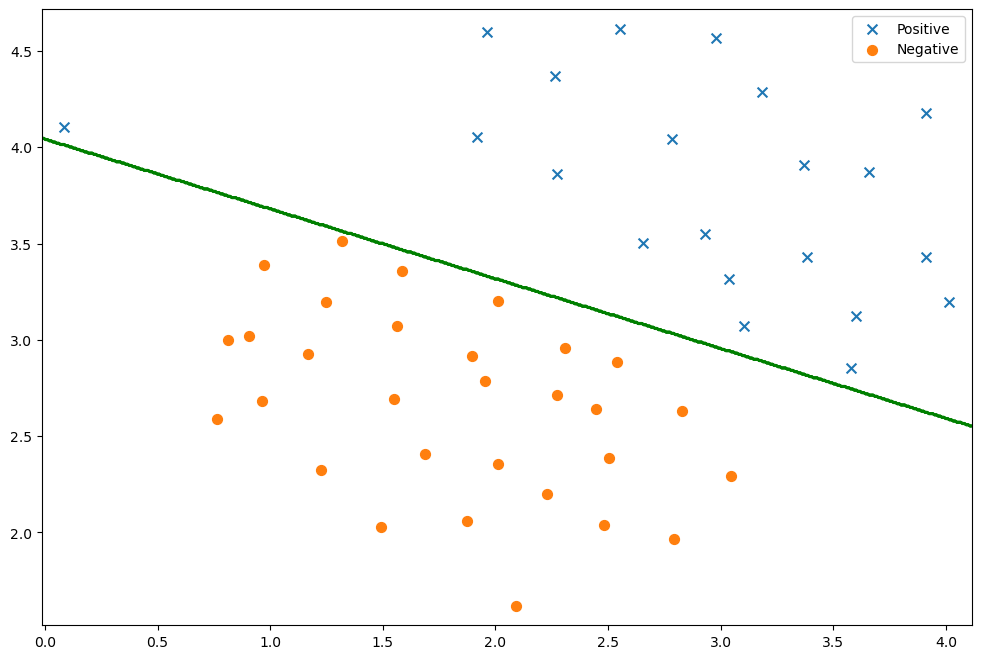

In [3]:
X1 = data1[['X1', 'X2']].values
y1 = data1['y'].values

svc1 = svm.LinearSVC(C=1, loss='hinge', max_iter=5000)
svc1.fit(X1, y1) # 导入数据进行训练
print('C=1:',svc1.score(X1, y1)) # 分类器的准确率

svc2 = svm.LinearSVC(C=450, loss='hinge', max_iter=300000)
svc2.fit(X1, y1)
print('C=450:', svc2.score(X1, y1))

plot_scatter(data1)
plot_boundary(svc1, data1, 0.1)
plot_scatter(data1)
plot_boundary(svc2, data1, 0.1)

### SVM with Gaussian Kernels 
使用带高斯核的SVMs来做非线性分类。
<img src = "gk.jpg" width = 570>

In [4]:
def gaussianKernel(x1, x2, sigma):
    return np.exp(- np.power(x1-x2, 2).sum() / (2*sigma**2))

x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

gaussianKernel(x1, x2, sigma)

0.32465246735834974

In [5]:
raw_data2 = loadmat('data/ex6data2.mat')
data2 = pd.DataFrame(raw_data2['X'], columns=['X1', 'X2'])
data2['y'] = raw_data2['y']
# plot_scatter(data2)

0.996523754345307


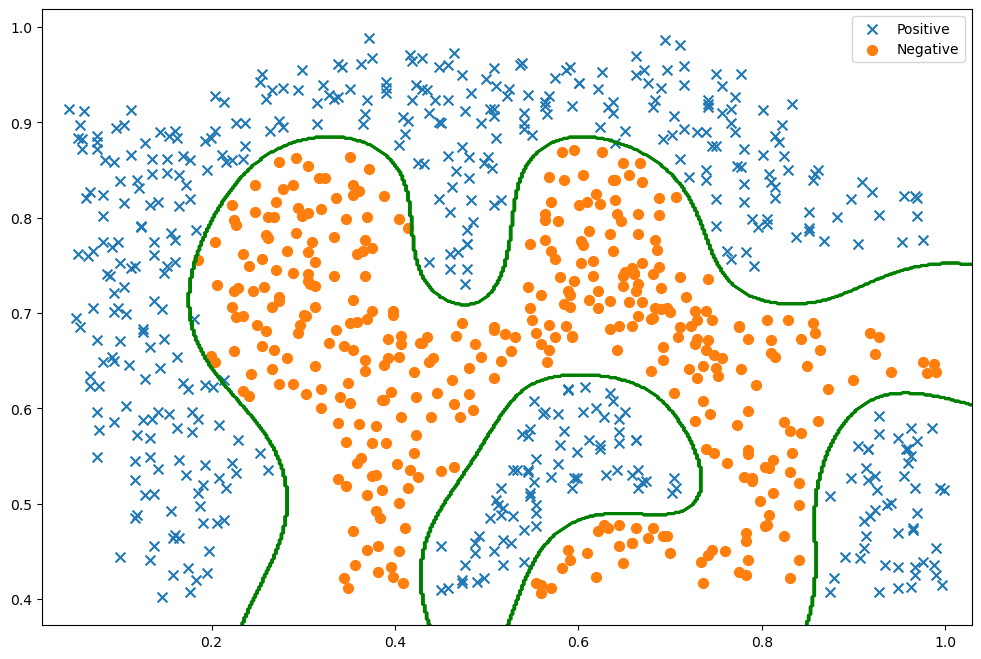

In [6]:
X2 = data2[['X1', 'X2']].values
y2 = data2['y'].values

svc3 = svm.SVC(C=30, kernel='rbf', gamma=50, probability=True)
svc3.fit(X2, y2)
print(svc3.score(X2, y2))

plot_scatter(data2)
plot_boundary(svc3, data2, 0.03)

### Best parameter C and $\sigma$
ex6data3.mat给出了变量X，y，Xval，yval。你的任务就是使用交叉验证集Xval，yval来决定要使用的最佳参数C和$\sigma$。

In [7]:
raw_data3 = loadmat('data/ex6data3.mat')

training_data = pd.DataFrame(raw_data3['X'], columns=['X1', 'X2'])
training_data['y'] = raw_data3['y']

validation_data = pd.DataFrame(raw_data3['Xval'], columns=['X1', 'X2'])
validation_data['y'] = raw_data3['yval']

best_C: 3 
best_gamma: 30 
max_score: 0.965


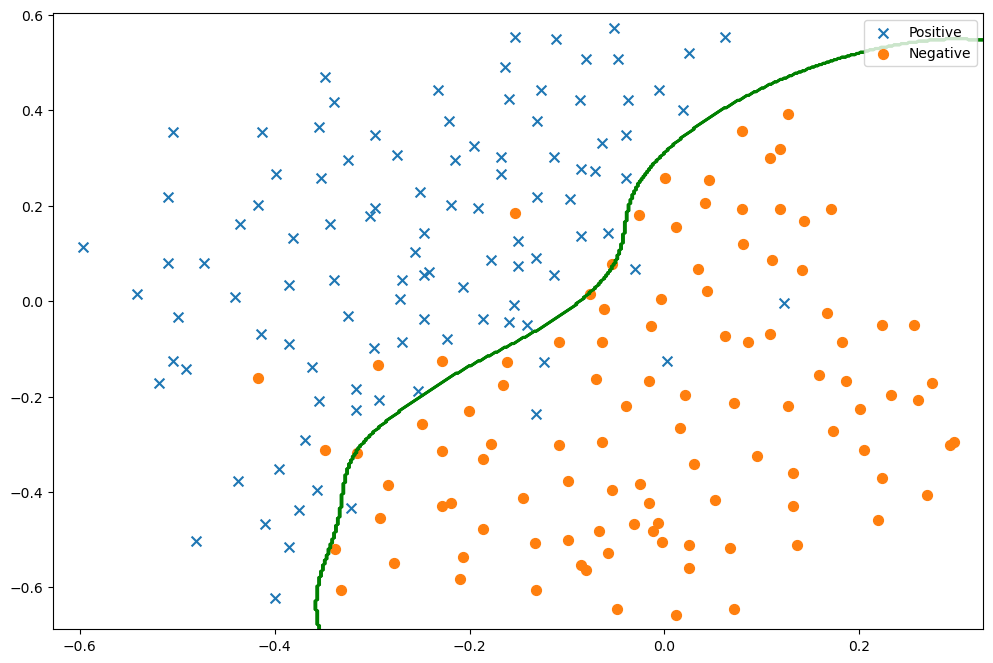

In [8]:
candidate = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30] 
combination = [(C, gamma) for C in candidate for gamma in candidate]

max_score = 0
best_C,best_gamma = 0, 0
training_X = training_data[['X1', 'X2']].values
training_y = training_data['y'].values
validation_X = validation_data[['X1', 'X2']].values
validation_y = validation_data['y'].values

for C, gamma in combination:
    svc = svm.SVC(C=C, kernel='rbf', gamma=gamma, probability=True)
    svc.fit(training_X, training_y)
    cur_score = svc.score(validation_X, validation_y)
    if cur_score > max_score:
        max_score = cur_score
        best_C = C
        best_gamma = gamma

print('best_C:', best_C, '\nbest_gamma:', best_gamma, '\nmax_score:', max_score)

best_svc = svm.SVC(C=best_C, kernel='rbf', gamma=best_gamma, probability=True)
best_svc.fit(training_X, training_y)

plot_scatter(training_data)
plot_boundary(best_svc, training_data, 0.03)

## 2. Spam Classification
训练一个分类器来分类给定的电子邮件是否是垃圾邮件（y = 1）还是非垃圾邮件（y = 0）。

### Preprocessing Emails
我们需要从一个电子邮件中构建特征向量。  
首先我们需要对电子邮件进行预处理以方便特征提取：
1. Lower-casing: 把整封邮件转化为小写。
2. Stripping HTML: 移除所有HTML标签，只保留内容。
3. Normalizing URLs: 将所有的URL替换为字符串 “httpaddr”.
4. Normalizing Email Addresses: 所有的地址替换为 “emailaddr”
5. Normalizing Dollars: 所有dollar符号($)替换为“dollar”.
6. Normalizing Numbers: 所有数字替换为“number”
7. Word Stemming(词干提取): 将所有单词还原为词源。例如，“discount”, “discounts”, “discounted” and “discounting”都替换为“discount”。
8. Removal of non-words: 移除所有非文字类型，所有的空格(tabs, newlines, spaces)调整为一个空格.


In [9]:
with open('data/emailSample1.txt', 'r') as f:
    email = f.read()
    print(email)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




In [10]:
import re # 正则表达式
import nltk

def preprocessEmail(email):
    email = email.lower()
    email = re.sub('<[^<>]>', ' ', email)  # 匹配<开头，然后所有不是< ,> 的内容，知道>结尾，相当于匹配<...>
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email )  # 匹配//后面不是空白字符的内容，遇到空白字符则停止
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email)
    email = re.sub('[\$]+', 'dollar', email)
    email = re.sub('[\d]+', 'number', email) 
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', email)
    stemmer = nltk.stem.porter.PorterStemmer()
    
    tokenlist = []
    for token in tokens:
        # 删除任何非字母数字的字符
        token = re.sub('[^a-zA-Z0-9]', '', token);
        # Use the Porter stemmer to 提取词根
        stemmed = stemmer.stem(token)
        # 去除空字符串‘’，里面不含任何字符
        if not len(token): continue
        tokenlist.append(stemmed)
            
    return tokenlist  

tokenlist = preprocessEmail(email)
print(tokenlist)

['anyon', 'know', 'how', 'much', 'it', 'cost', 'to', 'host', 'a', 'web', 'portal', 'well', 'it', 'depend', 'on', 'how', 'mani', 'visitor', 'you', 're', 'expect', 'thi', 'can', 'be', 'anywher', 'from', 'less', 'than', 'number', 'buck', 'a', 'month', 'to', 'a', 'coupl', 'of', 'dollarnumb', 'you', 'should', 'checkout', 'httpaddr', 'or', 'perhap', 'amazon', 'ecnumb', 'if', 'your', 'run', 'someth', 'big', 'to', 'unsubscrib', 'yourself', 'from', 'thi', 'mail', 'list', 'send', 'an', 'email', 'to', 'emailaddr']


### Extracting Features from Emails
- 在预处理完邮件后，下一步是选择我们想在分类器中使用哪些单词，以及我们想省略哪些单词。
- 我们有一个词汇表vocab.txt，里面存储了在实际中经常使用的单词，共1899个。
- 我们要算出处理后的email中含有多少vocab.txt中的单词，并返回在vocab.txt中的index，这就我们想要的训练单词的索引。
- 然后我们把每个邮件转换成一个1899维的向量$X$：$x_i=1$表示词汇表中的第i个词在这个邮件当中，$x_i=0$则表示不在


In [11]:
vocab = pd.read_table('data/vocab.txt',names=['words'])
vocab = vocab.values
index = [i for i in range(len(vocab)) if vocab[i] in tokenlist]
vector = np.zeros(len(vocab))
for i in index:
    vector[i] = 1
    
print('length of vector = {}\nnum of non-zero = {}'.format(len(vector), int(vector.sum())))

length of vector = 1899
num of non-zero = 45


### Training SVM for Spam Classification
使用已经预处理好的训练集来训练一个SVM分类器。  
spamTrain.mat包含4000个垃圾邮件和非垃圾邮件的训练样例，spamTest.mat包含了1000个测试样例。

In [12]:
mat1 = loadmat('data/spamTrain.mat')
X, y = mat1['X'], mat1['y']

mat2 = loadmat('data/spamTest.mat')
Xtest, ytest = mat2['Xtest'], mat2['ytest']

# svc4 = svm.LinearSVC(C=450, loss='hinge', max_iter=1000)
svc4 = svm.SVC(C=0.1, kernel='linear')
svc4.fit(X, y.ravel())

predTrain = svc4.score(X, y)
predTest = svc4.score(Xtest, ytest)
predTrain, predTest

(0.99825, 0.989)